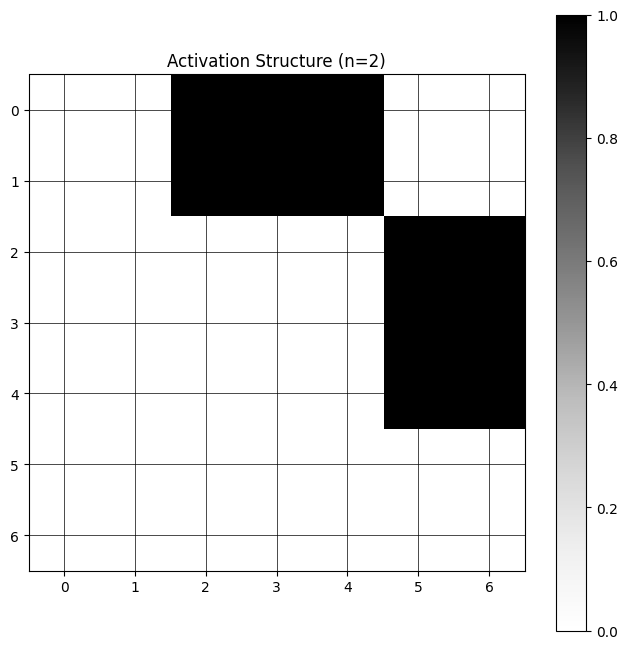

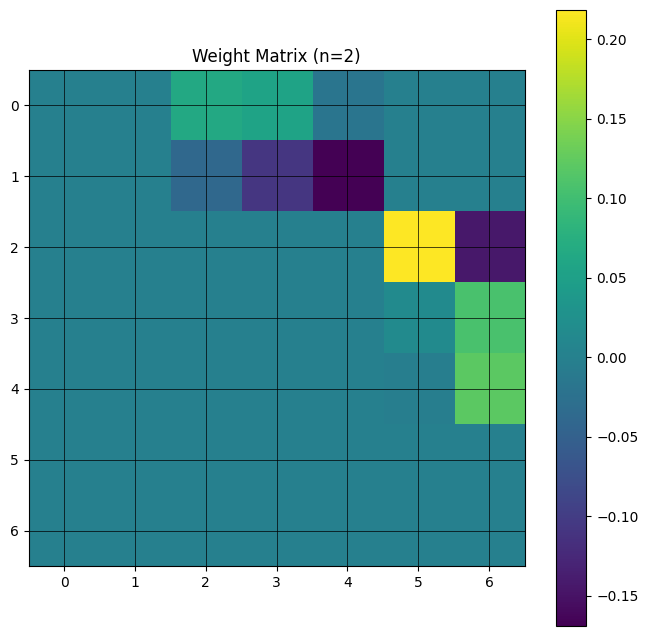

In [ ]:
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import numpy as np
import pickle

# Update the base class with the graph method
class BaseNeuralNetwork(ABC):
    @abstractmethod
    def save(self, filepath):
        pass

    @abstractmethod
    def load(self, filepath):
        pass

    @abstractmethod
    def train(self, data):
        pass

    @abstractmethod
    def test(self, x):
        pass

    def graph(self, activation_only=True):
        self._graphW(activation_only=activation_only)

# Update HexagonalNeuralNetwork to include _graphW and support all-zero W init
class HexagonalNeuralNetwork(BaseNeuralNetwork):
    def __init__(self, n, random_init=True):
        self.n = n
        self.layer_indices = self._get_default_layer_indices(n)
        self.total_nodes = sum(len(l) for l in self.layer_indices)
        self.W = self._init_weight_matrix(random_init=random_init)
        self.learning_rate = 0.01

    def _hex_layer_sizes(self, n):
        return list(range(n, 2*n)) + list(range(2*n - 2, n - 1, -1))

    def _get_default_layer_indices(self, n):
        sizes = self._hex_layer_sizes(n)
        indices = []
        start = 0
        for size in sizes:
            indices.append(list(range(start, start + size)))
            start += size
        return indices

    def _init_weight_matrix(self, random_init=True):
        W = np.zeros((self.total_nodes, self.total_nodes))
        for i in range(len(self.layer_indices) - 1):
            for u in self.layer_indices[i]:
                for v in self.layer_indices[i + 1]:
                    W[u, v] = np.random.randn() * 0.1 if random_init else 0.0
        return W

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_deriv(self, x):
        return (x > 0).astype(float)

    def forward(self, x):
        activations = [x.copy()]
        a = x.copy()
        for _ in range(len(self.layer_indices) - 1):
            a = self._relu(self.W @ a)
            activations.append(a.copy())
        return activations

    def backward(self, activations, target):
        grads = np.zeros_like(self.W)
        delta = (activations[-1] - target) * self._relu_deriv(activations[-1])
        for i in reversed(range(len(self.layer_indices) - 1)):
            src_nodes = self.layer_indices[i]
            dst_nodes = self.layer_indices[i + 1]
            for u in src_nodes:
                for v in dst_nodes:
                    grads[u, v] += delta[v] * activations[i][u]
            if i > 0:
                new_delta = np.zeros(len(activations[i]))
                for u in src_nodes:
                    s = sum(self.W[u, v] * delta[v] for v in dst_nodes)
                    new_delta[u] = s * self._relu_deriv(activations[i][u])
                delta = new_delta
        self.W -= self.learning_rate * grads

    def train(self, data):
        for x_input, y_target in data:
            x0 = np.zeros(self.total_nodes)             # init input vector
            x0[self.layer_indices[0]] = x_input         # padding (ex [x_0, x_1, 0, 0, 0, 0, 0])
            y_full = np.zeros(self.total_nodes)         # init output vector
            y_full[self.layer_indices[-1]] = y_target   # padding (ex [0, 0, 0, 0, 0, y_0, y_1])
            activations = self.forward(x0)
            self.backward(activations, y_full)

    def test(self, x_input):
        x0 = np.zeros(self.total_nodes)
        x0[self.layer_indices[0]] = x_input
        activations = self.forward(x0)
        return activations[-1][self.layer_indices[-1]]

    def save(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump({'n': self.n, 'W': self.W}, f)

    def load(self, filepath):
        with open(filepath, 'rb') as f:
            state = pickle.load(f)
            self.n = state['n']
            self.layer_indices = self._get_default_layer_indices(self.n)
            self.total_nodes = sum(len(l) for l in self.layer_indices)
            self.W = state['W']

    def _graphW(self, activation_only=True):
        title = "Activation Structure" if activation_only else "Weight Matrix"
        matrix = (self.W != 0).astype(int) if activation_only else self.W

        plt.figure(figsize=(8, 8))
        plt.imshow(matrix, cmap='Greys' if activation_only else 'viridis', interpolation='none')
        plt.title(title + f" (n={self.n})")
        plt.xticks(np.arange(self.total_nodes))
        plt.yticks(np.arange(self.total_nodes))
        plt.grid(visible=True, color='black', linewidth=0.5)
        plt.colorbar()
        plt.show()

n = 2
hexnet = HexagonalNeuralNetwork(n)
hexnet._graphW(True)

# data = np.array([
#     # ([0.1, 0.2], [0.2, 0.4]),
#     # ([0.5, 0.6], [1.0, 1.2]),
#     # ([0.3, 0.4], [0.6, 0.8]),
#     # ([0.7, 0.8], [1.4, 1.6]),
#     # ([0.9, 1.0], [1.8, 2.0])
#     ([x0, x1], [2 * x0, 2 * x1]) 
#     for x0 in np.arange(-1.0, 1.0, 0.1) for x1 in np.arange(-1.0, 1.0, 0.1)
# ])

# simple dataset: inputs in {0,1}^n and targets = inputs (identity) for demo
train_samples = 1000
X = (np.random.rand(train_samples, n) * 2 - 1).astype(float)
# Y = X.copy()
Y = X.copy() * 2
data = list(zip(X, Y))
# for x_input, y_target in data:
#     x0 = np.zeros(hexnet.total_nodes)             # init input vector
#     x0[hexnet.layer_indices[0]] = x_input         # padding (ex [x_0, x_1, 0, 0, 0, 0, 0])
#     y_full = np.zeros(hexnet.total_nodes)         # init output vector
#     y_full[hexnet.layer_indices[-1]] = y_target   # padding (ex [0, 0, 0, 0, 0, y_0, y_1])

#     print('padded input:', x0)
#     print('padded target:', y_full)

hexnet.train(data)
hexnet._graphW(False)
